# Korteweg-de Vries equation

in this notebook we provide a simple example of the DeepMoD algorithm and apply it on the Korteweg-de Vries equation. 

Set the noise level, number of samples, architecture and strength of the $L_1$ Penalty

In [1]:
import numpy as np
import pandas as pd 

from deepymod.DeepMoD import DeepMoD
from deepymod.library_functions import library_1D
from deepymod.utilities import library_matrix_mat, print_PDE

import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')

np.random.seed(42)  # setting seed for randomisation

Set the noise level, number of samples, architecture and strength of the $L_1$ Penalty

In [2]:
noise_level = 0.1
number_of_samples = 1000
layers = [2, 20, 20, 20, 20, 20, 1]
l1 = 10**-6

We import the ground truth data and add white noise to the solution. Next, we randomely select a pre-set number of samples.   

In [3]:
# %%Importing and preparing data
data = np.load('data/kdv.npy').item()

X = np.transpose((data['x'].flatten(), data['t'].flatten()))
y = np.real(data['u']).reshape((data['u'].size, 1))
y_noisy = y + noise_level * np.std(y) * np.random.randn(y.size, 1)

idx = np.random.permutation(y.size)
X_train = X[idx, :][:number_of_samples]
y_train = y[idx, :][:number_of_samples]

Configure DeepMoD and the library function. 
- Set the number of terms in the library function (select max. order of derivative and polynomial). 
- Set the training options 
- Select the output directory for the TensorBoard files

In [4]:
config = {'layers': layers, 'lambda': l1}
library_config = {'total_terms': 12, 'deriv_order': 3, 'poly_order': 2}
train_opts = {'max_iterations': 50000, 'grad_tol':10**-7, 'learning_rate': 0.002, 'beta1': 0.99, 'beta2': 0.999, 'epsilon': 10**-8}
output_opts = {'output_directory': 'output/kdv/', 'X_predict': X}

Running DeepMoD using the 1D library:

In [5]:
sparse_vectors, denoised = DeepMoD(X_train, y_train, config, library_1D, library_config, train_opts, output_opts)

Epoch | Total loss | Loss gradient | MSE | PI | L1 
0 [0.3738098, 0.009035587, 0.034543417, 0.33926037, 6.025783e-06]
500 [0.0069807805, 0.0003295963, 0.006015573, 0.0009557361, 9.471095e-06]
1000 [0.005125937, 0.0005962962, 0.004086756, 0.0010316925, 7.488498e-06]
1500 [0.004372843, 0.0005894068, 0.0034781494, 0.0008880222, 6.671633e-06]
2000 [0.003848418, 0.0005365397, 0.003130825, 0.00071151264, 6.080375e-06]
2500 [0.0033291583, 0.00045421463, 0.0028214168, 0.00050237664, 5.364955e-06]
3000 [0.0023596971, 0.00034169297, 0.0020362206, 0.00031910316, 4.373183e-06]
3500 [0.00029459686, 0.00020414381, 0.00013638783, 0.00015443655, 3.7724633e-06]
4000 [0.0001246324, 0.000100197925, 5.532926e-05, 6.514147e-05, 4.161678e-06]
4500 [6.0171416e-05, 7.1961105e-05, 2.2517188e-05, 3.316699e-05, 4.4872395e-06]
5000 [4.2077154e-05, 0.00011437548, 1.3410911e-05, 2.3909233e-05, 4.757009e-06]
5500 [3.8839476e-05, 0.0001561103, 1.3194047e-05, 2.086688e-05, 4.77855e-06]
6000 [2.674256e-05, 6.0788017e-0

Show final result:

In [10]:
u = ['1', 'u', 'uˆ2']
du = ['1', 'u_{x}', 'u_{xx}', 'u_{xxx}']
coeffs_list = library_matrix_mat(u, du)

print('Inferred equation:')
print_PDE(sparse_vectors[0], coeffs_list, PDE_term='u_t')

Inferred equation:
u_t = 0.997u_{xxx} - 5.992uu_{x}


Plot the 'Ground truth', 'Noisy' and 'Reconstructed/Denoised' solution

In [11]:
data= {'x_grid': X[:, 0], 't_grid': X[:, 1], 'ground truth': y, 'noisy': y_noisy, 'inferred': denoised}
for key in data:
    data[key] = np.squeeze(data[key])
data = pd.DataFrame(data)
train_idx = np.random.permutation(data['t_grid'].size)[:number_of_samples]
data['train set'] = [data['noisy'][index] if index in train_idx else None for index in np.arange(data['t_grid'].size)]

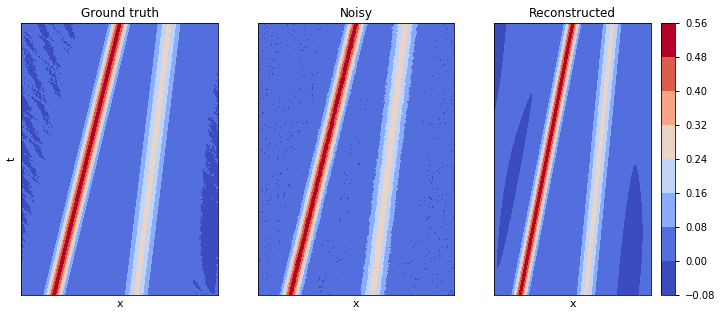

In [12]:
vmin = data['ground truth'].min()
vmax =data['ground truth'].max()

fig, [ax1, ax2, ax3] = plt.subplots(ncols=3, nrows=1, figsize= (12, 5))
np.count_nonzero(~np.isnan(data['train set']))

im1 = ax1.contourf(data.pivot(index='t_grid', columns='x_grid', values='ground truth'), cmap='coolwarm',vmin=vmin, vmax=vmax)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlabel('x')
ax1.set_ylabel('t')
ax1.set_title('Ground truth')

im2 = ax2.contourf(data.pivot(index='t_grid', columns='x_grid', values='noisy'), cmap='coolwarm', vmin=vmin, vmax=vmax)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlabel('x')
ax2.set_title('Noisy')

im3 = ax3.contourf(data.pivot(index='t_grid', columns='x_grid', values='inferred'), cmap='coolwarm', vmin=vmin, vmax=vmax)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_xlabel('x')
ax3.set_title('Reconstructed')
plt.colorbar(im3)